# Restoring Color to Greyscale Images

In [1]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

import lasagne
import theano
import theano.tensor as T

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [63]:
import convnets
import train
reload(convnets)
reload(train)

SIZE = 100
IMDIR = "images/raw"

handles = [os.path.join(IMDIR, h) for h in os.listdir(IMDIR)]
print len(handles)

30113


In [64]:
base = convnets.COLOR_STATS_NET
theano_exprs = convnets.CreateTheanoExprs(
    base_net=base,
    height=SIZE,
    width=SIZE,
    learning_rate=0.001)
net, train_fn, val_fn, prediction, target_var, transformed_target = theano_exprs[:6]
convnets.PrintNetworkShape(net)

DenseLayer (None, 100) => (None, 6)
DenseLayer (None, 5, 23, 23) => (None, 100)
MaxPool2DLayer (None, 5, 46, 46) => (None, 5, 23, 23)
Conv2DLayer (None, 12, 48, 48) => (None, 5, 46, 46)
MaxPool2DLayer (None, 12, 96, 96) => (None, 12, 48, 48)
Conv2DLayer (None, 1, 100, 100) => (None, 12, 96, 96)
DimshuffleLayer (None, 100, 100) => (None, 1, 100, 100)
InputLayer  => (None, 100, 100)


In [66]:
batch_stats, val_stats, err, net  = train.Train(
    num_batches=20,
    validate_every_n_batches=4,
    height=SIZE,
    width=SIZE,
    batch_size=100,
    reps_per_batch=2,
    image_handles=handles,
    val_set_size=500,
    test_set_size=500,
    net=net,
    train_fn=train_fn,
    val_fn=val_fn)

Loading validation and testing images...
Starting training...
Training batch 0 of 2 x 100 images. Last time = 0.00 seconds. Last load time = 1.63 seconds. Last error = 1.00000.
Training batch 1 of 2 x 100 images. Last time = 1.00 seconds. Last load time = 1.39 seconds. Last error = 1.55282.
Training batch 2 of 2 x 100 images. Last time = 1.12 seconds. Last load time = 1.39 seconds. Last error = 1.38594.
Training batch 3 of 2 x 100 images. Last time = 1.03 seconds. Last load time = 1.32 seconds. Last error = 1.25605.

Validating...
Validated on 500 images in 1.51 seconds. Error = 1.09702.

Training batch 4 of 2 x 100 images. Last time = 1.08 seconds. Last load time = 1.35 seconds. Last error = 1.15785.
Training batch 5 of 2 x 100 images. Last time = 1.37 seconds. Last load time = 1.60 seconds. Last error = 1.08971.
Training batch 6 of 2 x 100 images. Last time = 1.16 seconds. Last load time = 1.40 seconds. Last error = 1.03964.
Training batch 7 of 2 x 100 images. Last time = 1.05 second

In [6]:
images = np.zeros((100, SIZE, SIZE, 3))
train.LoadImages(handles, SIZE, SIZE, 100, images)

101

In [7]:
def ImStat(images):
    for i, color in enumerate(["  red", "green", " blue"]):
        channel = images[:, :, :, i]
        print "{c}: mean={m:.2f}, std={s:.2f}".format(
            c=color, m=channel.mean(), s=channel.std())
    grey = (images[:, :, :, 0] * 0.299 +
            images[:, :, :, 1] * 0.587 +
            images[:, :, :, 2] * 0.114)
    print " grey: mean={m:.2f}, std={s:.2f}".format(
        m=grey.mean(), s=grey.std())
    
    sh = images.shape
    rsh = (sh[0], sh[1] * sh[2], sh[3])
    ch = images.reshape(rsh)
    means = ch.mean(axis=1)
    stds = ch.std(axis=1)
    print "Mean of Means:", means.mean(axis=0)
    print " Std of Means:", means.std(axis=0)
    print " Mean of Stds:", stds.mean(axis=0)
    print "  Std of Stds:", stds.std(axis=0)

In [8]:
ImStat(images)

  red: mean=126.99, std=69.70
green: mean=136.61, std=67.88
 blue: mean=148.99, std=73.16
 grey: mean=135.15, std=66.31
Mean of Means: [ 126.989014  136.610888  148.994259]
 Std of Means: [ 39.63258256  39.60512887  46.70437152]
 Mean of Stds: [ 54.71197316  52.48722761  53.37689392]
  Std of Stds: [ 17.12463232  16.8657054   17.94935142]


In [43]:
evaluator = train.Evaluator(prediction, target_var, transformed_target)

In [55]:
evaluator(images[np.random.randint(0, len(images))])

[array([[-0.24561741, -0.09533195, -0.2080202 ,  0.21776753, -0.26968742,
         -0.19626031]]),
 array([[ 0.38071619, -0.42554809, -1.30481532, -1.46501344, -0.94421481,
         -0.29198509]])]

In [58]:
images.shapejavascript:void(0)

(100, 100, 100, 3)

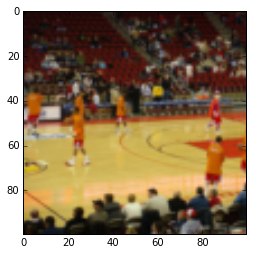

In [62]:
plt.imshow(np.repeat(images, 5, 0)[-123])

In [67]:
net